In [13]:
"""
CAPM + Black-Scholes demo with a simple backtest on real stock data (Jupyter-friendly).
"""

from __future__ import annotations

from dataclasses import dataclass
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

TRADING_DAYS = 252

In [14]:
# -----------------------------
# Config (edit this in Jupyter)
# -----------------------------
args = {
    "ticker": "NVDA",
    "market": "^IXIC",
    "start": "2021-01-15",
    "end": None,          # None = up to most recent
    "risk_free": 0.02,    # annual
    "window": 126,        # rolling window for beta/market mean
    "strike": None,       # None = 5% above spot
    "days": 30,           # option days to expiry
}

In [15]:
@dataclass
class BacktestResult:
    strategy_return: float
    buy_hold_return: float
    hit_rate: float
    total_days: int


def black_scholes_call(spot: float, strike: float, time_years: float, rate: float, vol: float) -> float:
    if spot <= 0 or strike <= 0 or time_years <= 0 or vol <= 0:
        raise ValueError("Spot, strike, time, and volatility must be positive.")

    d1 = (np.log(spot / strike) + (rate + 0.5 * vol**2) * time_years) / (vol * np.sqrt(time_years))
    d2 = d1 - vol * np.sqrt(time_years)
    return float(spot * norm.cdf(d1) - strike * np.exp(-rate * time_years) * norm.cdf(d2))


def fetch_prices(ticker: str, start: str, end: str | None) -> pd.Series:
    data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    if data.empty:
        raise ValueError(f"No data returned for {ticker}. Check ticker/date range or internet access.")
    close = data["Close"]

    # yfinance may return Close as a DataFrame (not a Series)
    if isinstance(close, pd.DataFrame):
        # if only one column, take it
        if close.shape[1] == 1:
            close = close.iloc[:, 0]
        # if multiple columns (multi-ticker), take the ticker column if present
        elif ticker in close.columns:
            close = close[ticker]
        else:
            close = close.iloc[:, 0]

    return close.rename(ticker)


def compute_returns(prices: pd.Series) -> pd.Series:
    return prices.pct_change().dropna()

In [16]:
def rolling_beta(stock_ret: pd.Series, market_ret: pd.Series, window: int) -> pd.Series:
    cov = stock_ret.rolling(window).cov(market_ret)
    var = market_ret.rolling(window).var()
    return cov / var


def backtest_capm_strategy(
    stock_ret: pd.Series,
    market_ret: pd.Series,
    rf_annual: float,
    window: int,
) -> tuple[BacktestResult, pd.DataFrame]:
    rf_daily = (1 + rf_annual) ** (1 / TRADING_DAYS) - 1

    beta = rolling_beta(stock_ret, market_ret, window)
    market_mean = market_ret.rolling(window).mean()

    expected_daily = rf_daily + beta * (market_mean - rf_daily)
    signal = expected_daily > 0

    strategy_returns = signal.shift(1).fillna(False).astype(float) * stock_ret

    equity_strategy = (1 + strategy_returns).cumprod()
    equity_buyhold = (1 + stock_ret).cumprod()

    cumulative_strategy = float(equity_strategy.iloc[-1] - 1)
    cumulative_buy_hold = float(equity_buyhold.iloc[-1] - 1)

    traded_days = (strategy_returns != 0).sum()
    hit_rate = float((strategy_returns > 0).sum() / max(traded_days, 1))

    bt = BacktestResult(
        strategy_return=cumulative_strategy,
        buy_hold_return=cumulative_buy_hold,
        hit_rate=hit_rate,
        total_days=int(strategy_returns.count()),
    )

    df = pd.DataFrame({
        "stock_ret": stock_ret,
        "market_ret": market_ret,
        "beta_roll": beta,
        "expected_daily": expected_daily,
        "signal": signal.astype(int),
        "strategy_ret": strategy_returns,
        "equity_strategy": equity_strategy,
        "equity_buyhold": equity_buyhold,
    }).dropna()

    return bt, df


def summarize_capm(stock_ret: pd.Series, market_ret: pd.Series, rf_annual: float) -> dict:
    beta = float(stock_ret.cov(market_ret) / market_ret.var())
    expected_market = float(market_ret.mean() * TRADING_DAYS)
    expected_stock = float(rf_annual + beta * (expected_market - rf_annual))
    vol = float(stock_ret.std() * np.sqrt(TRADING_DAYS))
    return {"beta": beta, "expected_market": expected_market, "expected_stock": expected_stock, "vol": vol}

CAPM Summary
------------
Ticker: NVDA
Market: ^IXIC
Beta: 1.813
Expected annual return (CAPM): 24.61%

Black-Scholes Call
------------------
Spot: 187.05
Strike: 196.40
Volatility (annualized): 52.05%
Days to expiry: 30
Call price: 9.71

CAPM Strategy Backtest
----------------------
Strategy return: 611.66%
Buy & hold return: 1358.66%
Hit rate (on traded days): 53.47%
Total trading days: 1255


/var/folders/6f/9bpsqnv56y3_09ry23_1dc7m0000gn/T/ipykernel_86306/2796866348.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strategy_returns = signal.shift(1).fillna(False).astype(float) * stock_ret


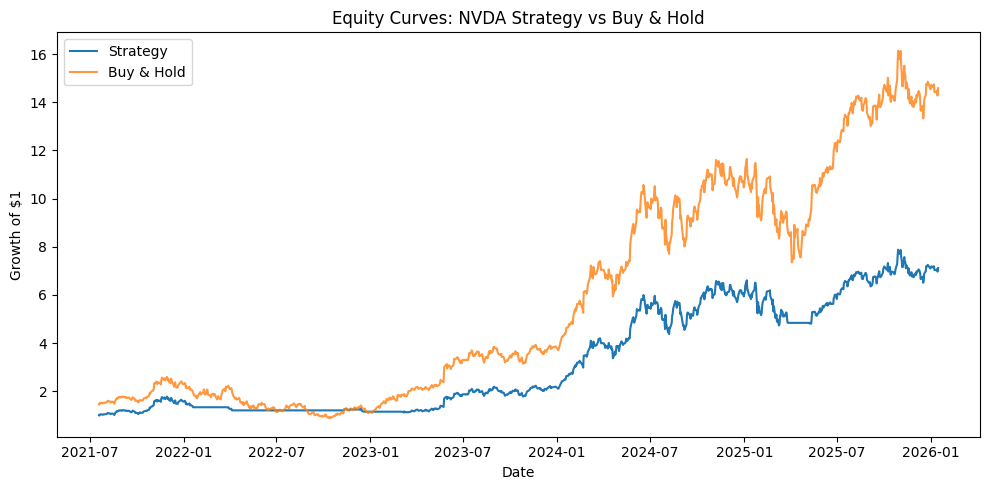

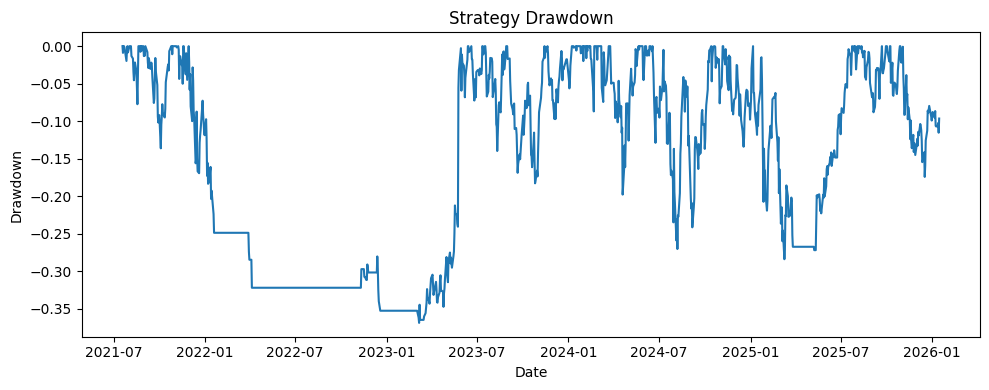

,stock_ret,market_ret,beta_roll,expected_daily,signal,strategy_ret,equity_strategy,equity_buyhold
Date,,,,,,,,
2026-01-09,-0.000973,0.008149,1.491391,0.001684,1,-0.000973,7.033306,14.415791
2026-01-12,0.000433,0.002642,1.492136,0.001684,1,0.000433,7.036349,14.422030
2026-01-13,0.004704,-0.001013,1.488581,0.001647,1,0.004704,7.069450,14.489874
2026-01-14,-0.014370,-0.010043,1.487126,0.001497,1,-0.014370,6.967865,14.281662
2026-01-15,0.021350,0.002483,1.489970,0.001440,1,0.021350,7.116628,14.586572


In [17]:
# -----------------------------
# Run (one cell)
# -----------------------------
stock_prices = fetch_prices(args["ticker"], args["start"], args["end"])
market_prices = fetch_prices(args["market"], args["start"], args["end"])

combined = pd.concat([stock_prices, market_prices], axis=1, join="inner")
stock_ret = compute_returns(combined[args["ticker"]])
market_ret = compute_returns(combined[args["market"]])

aligned = pd.concat([stock_ret, market_ret], axis=1, join="inner")
stock_ret = aligned[args["ticker"]]
market_ret = aligned[args["market"]]

capm = summarize_capm(stock_ret, market_ret, args["risk_free"])

spot = float(combined[args["ticker"]].iloc[-1])
strike = float(args["strike"] if args["strike"] is not None else spot * 1.05)
time_years = float(args["days"] / TRADING_DAYS)
call_price = black_scholes_call(spot, strike, time_years, args["risk_free"], capm["vol"])

backtest, bt_df = backtest_capm_strategy(stock_ret, market_ret, args["risk_free"], args["window"])

print("CAPM Summary")
print("------------")
print(f"Ticker: {args['ticker']}")
print(f"Market: {args['market']}")
print(f"Beta: {capm['beta']:.3f}")
print(f"Expected annual return (CAPM): {capm['expected_stock']:.2%}")
print()

print("Black-Scholes Call")
print("------------------")
print(f"Spot: {spot:.2f}")
print(f"Strike: {strike:.2f}")
print(f"Volatility (annualized): {capm['vol']:.2%}")
print(f"Days to expiry: {args['days']}")
print(f"Call price: {call_price:.2f}")
print()

print("CAPM Strategy Backtest")
print("----------------------")
print(f"Strategy return: {backtest.strategy_return:.2%}")
print(f"Buy & hold return: {backtest.buy_hold_return:.2%}")
print(f"Hit rate (on traded days): {backtest.hit_rate:.2%}")
print(f"Total trading days: {backtest.total_days}")

# -----------------------------
# Plots (equity + drawdown)
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(bt_df.index, bt_df["equity_strategy"], label="Strategy")
plt.plot(bt_df.index, bt_df["equity_buyhold"], label="Buy & Hold", alpha=0.8)
plt.title(f"Equity Curves: {args['ticker']} Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.tight_layout()
plt.show()

drawdown = bt_df["equity_strategy"] / bt_df["equity_strategy"].cummax() - 1
plt.figure(figsize=(10, 4))
plt.plot(bt_df.index, drawdown)
plt.title("Strategy Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.tight_layout()
plt.show()

# Optional: view last rows
bt_df.tail()